In [60]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import lsqfit
import itertools
from tqdm import tqdm

In [61]:
from b2heavy.FnalHISQMetadata import params as mData

In [62]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [156]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
# DATA_DIR = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/CORRELATORS'
# DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [157]:
ENSEMBLE = 'Coarse-Phys'
RATIO    = 'XV'
MOMENTUM = '400'

SMSLIST  = ['1S','RW']
# SMSLIST  = ['1S']

if RATIO in ['RMINUS','RPLUS','QPLUS','XF']:
    meson = 'D'
elif RATIO in ['RA1','ZRA1','XFSTPAR','XV','R0','R1']:
    meson = 'Dst'
elif RATIO in ['RA1S','ZRA1S','XFSSTPAR','XVS','R0S','R1S']:
    meson = 'Dsst'

In [158]:
# Correlation matrix specifics
DIAG   = False
BLOCK  = False
SCALE  = True
SHRINK = True
SVD    = 1E-12

In [159]:
# Specifics of the analysis
TMIN    = 1
NSTATES = 2
WPRIORS = True

In the following we look for requisites for the ratio calculation

In [160]:
requisites = ratio_prerequisites(
    ens      = ENSEMBLE,
    ratio    = RATIO,
    mom      = MOMENTUM,
    readfrom = DATA_2PT,
    jk       = True
)

Here we initialize the master object that contains a ratio at given momentum for a given ensemble

In [161]:
io = RatioIO(ENSEMBLE,RATIO,MOMENTUM,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ENSEMBLE],
    smearing  = SMSLIST,
    **requisites
)

In [162]:
robj.format()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 {'1S': array([0.825(34), 0.5102(94), 0.5108(98), 0.527(12), 0.546(14), 0.546(14),
         0.545(15), 0.555(16), 0.540(16), 0.533(15), 0.543(15), 0.538(12),
         -0.122(85)], dtype=object),
  'RW': array([0.472(24), 0.5144(98), 0.527(10), 0.531(10), 0.537(11), 0.552(10),
         0.560(12), 0.574(14), 0.572(14), 0.566(14), 0.570(15), 0.562(12),
         0.093(66)], dtype=object)})

In [163]:
trange = (TMIN, robj.Ta-TMIN)

In [164]:
cov_specs = dict(
    diag   = DIAG  ,
    block  = BLOCK ,
    scale  = SCALE ,
    shrink = SHRINK,
    cutsvd = 1E-12
)

cov_specs

{'diag': False, 'block': False, 'scale': True, 'shrink': True, 'cutsvd': 1e-12}

Here we compute fit priors

In [165]:
fit,p = read_config_fit(
    tag  = f'fit2pt_config_{ENSEMBLE}_Dst_100',
    path = DATA_2PT
)

In [166]:
p

BufferDict({'dE': array([1.0884(24), -0.92(30), -0.53(46)], dtype=object), 'dE.o': array([-2.07(38), -2.55(69), -0.28(23)], dtype=object), 'Z.d.Par': array([-1.954(18), 0.204(95), 0.65(39)], dtype=object), 'Z.d.Par.o': array([-5.9(2.0), 0.122(11), 0.62(28)], dtype=object), 'Z.d.Bot': array([-1.960(17), 0.196(95), 0.69(42)], dtype=object), 'Z.d.Bot.o': array([-3.52(68), -0.121(10), 0.60(28)], dtype=object), 'Z.1S.Par': array([0.407(14), 0.73(37), 2.3(2.0)], dtype=object), 'Z.1S.Par.o': array([-0.91(57), 0.99(16), 1.8(1.1)], dtype=object), 'Z.1S.Bot': array([0.395(14), 0.83(32), 1.5(1.8)], dtype=object), 'Z.1S.Bot.o': array([-0.42(52), 0.80(36), 2.6(1.1)], dtype=object), 'Z.d-1S.Par': array([0.42(15), 0.40(89)], dtype=object), 'Z.d-1S.Par.o': array([0.362(30), 0.91(26)], dtype=object), 'Z.d-1S.Bot': array([0.40(15), 0.70(34)], dtype=object), 'Z.d-1S.Bot.o': array([0.339(43), 0.82(28)], dtype=object)})

In [167]:
dE_src = phys_energy_priors(ENSEMBLE,meson,MOMENTUM,NSTATES,readfrom=DATA_2PT,error=1.0)
dE_snk = phys_energy_priors(ENSEMBLE,'B',MOMENTUM,NSTATES,readfrom=DATA_2PT,error=1.0)

pr = robj.priors(NSTATES, dE_src=dE_src, dE_snk=dE_snk)
pr

{'ratio': [0.55(10)],
 'A_1S': [0 ± 1.0, 0 ± 1.0],
 'B_1S': [0 ± 1.0, 0 ± 1.0],
 'A_RW': [0 ± 1.0, 0 ± 1.0],
 'B_RW': [0 ± 1.0, 0 ± 1.0],
 'dE_src': [1.2(1.0), -1.3(1.0)],
 'dE_snk': [1.9(1.0), -1.1(1.0)]}

Here we perform the fit

In [168]:
fit = robj.fit(
    Nstates = NSTATES,
    trange  = trange,
    priors  = pr,
    verbose = False,
    **cov_specs,
)

In [169]:
res = robj.fit_result(
    Nexc   = NSTATES,
    trange = trange,
    verbose = True,
    priors = pr 
)

# ---------- chi^2_exp analysis -------------
# chi2_exp = 21.999999999999797 +/- 6.6332495807108165 
# p-value [eval] = 0.0175
# p-value [MC]   = 0.018000000000000016
# ---------- 2+2 fit in (1, 11) for mes: XV of ens: Coarse-Phys for mom: 400 --------------
Least Square Fit:
  chi2/dof [dof] = 1.4 [22]    Q = 0.099    logGBF = 50.05

Parameters:
        ratio 0   0.535 (16)     [  0.55 (10) ]  
         A_1S 0    0.81 (75)     [    0 ± 1.0 ]  
              1   -0.35 (41)     [    0 ± 1.0 ]  
         B_1S 0    0.03 (17)     [    0 ± 1.0 ]  
              1   -0.04 (13)     [    0 ± 1.0 ]  
         A_RW 0   -0.10 (38)     [    0 ± 1.0 ]  
              1   -0.05 (13)     [    0 ± 1.0 ]  
         B_RW 0   -0.28 (17)     [    0 ± 1.0 ]  
              1    0.24 (20)     [    0 ± 1.0 ]  
       dE_src 0    0.84 (74)     [  1.2 (1.0) ]  
              1   -0.17 (59)     [ -1.3 (1.0) ]  *
       dE_snk 0    0.02 (70)     [  1.9 (1.0) ]  *
              1   -1.17 (55)     [ -1.1 (1.0) ] 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


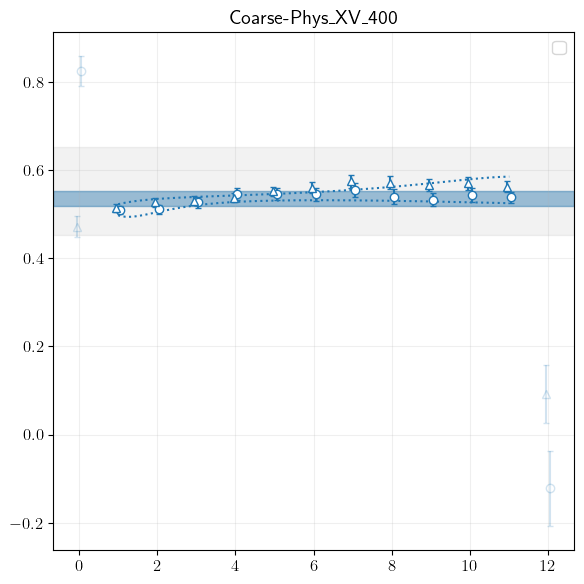

In [170]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

# f, ax = plt.subplots(1,1,figsize=(8,4))
f, ax = plt.subplots(1,1,figsize=(6,6))

robj.plot_fit(ax,NSTATES,trange)

f0 = pr['ratio'][0]
ax.axhspan(ymin=f0.mean-f0.sdev,ymax=f0.mean+f0.sdev,alpha=0.1,color='gray')

# ax.set_xlim(-0.5,18)
ax.grid(alpha=0.2)
ax.legend()
ax.set_title(f'{ENSEMBLE}_{RATIO}_{MOMENTUM}')
plt.tight_layout()
# plt.savefig('/Users/pietro/Desktop/bad_ratio.pdf')

# Model average for `Nstates` and trange

In [153]:
TIC = {}
pval = {}
for Nstates in [1,2,3]:
    dE_src = phys_energy_priors(ENSEMBLE,'Dst',MOMENTUM,Nstates,readfrom=DATA_2PT)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,MOMENTUM,Nstates,readfrom=DATA_2PT)
    x,ydata = robj.format(trange,flatten=True)
    pr = robj.priors(Nstates, dE_src=dE_src, dE_snk=dE_snk)

    for tmin in [1,2,3,4]:
        print(f'{Nstates=},{tmin=}')

        trange = (tmin, robj.Ta-tmin)

        fit = robj.fit(
            Nstates = Nstates,
            trange  = trange,
            priors  = pr,
            verbose = False,
            **cov_specs
        )

        res = robj.fit_result(
            Nexc   = Nstates,
            trange = trange,
            priors = pr,
            verbose = False
        )
        TIC[Nstates,trange] = float((res['chi2aug'] - 2*res['chiexp']))
        pval[Nstates,trange] = res['pstd']

Nstates=1,tmin=1
# ---------- chi^2_exp analysis -------------
# chi2_exp = 22.000000000000185 +/- 6.633249580710827 
# p-value [eval] = 0.0
# p-value [MC]   = 0.0
Nstates=1,tmin=2
# ---------- chi^2_exp analysis -------------
# chi2_exp = 17.999999999999925 +/- 6.000000000000007 
# p-value [eval] = 0.0001
# p-value [MC]   = 0.00029999999999996696
Nstates=1,tmin=3
# ---------- chi^2_exp analysis -------------
# chi2_exp = 13.999999999999998 +/- 5.291502622129188 
# p-value [eval] = 0.0025
# p-value [MC]   = 0.0020000000000000018
Nstates=1,tmin=4
# ---------- chi^2_exp analysis -------------
# chi2_exp = 9.99999999999999 +/- 4.472135954999563 
# p-value [eval] = 0.0055
# p-value [MC]   = 0.0046000000000000485
Nstates=2,tmin=1
# ---------- chi^2_exp analysis -------------
# chi2_exp = 21.99999999999968 +/- 6.633249580710793 
# p-value [eval] = 0.0
# p-value [MC]   = 0.0
Nstates=2,tmin=2
# ---------- chi^2_exp analysis -------------
# chi2_exp = 18.00000000000031 +/- 6.000000000000006 
# 

In [154]:
norm = np.exp(-np.array(list(TIC.values()))/2).sum()

vals = np.array([f.p['ratio'][0] for k,f in robj.fits.items()])
weig = np.array([np.exp(-TIC[k]/2)/norm for k in robj.fits]   )

stat = sum(vals * weig)
syst = np.sqrt(gv.mean(sum(weig*vals*vals) - (sum(weig*vals))**2))


print(stat,syst)

0.529(56) 0.011523920863365943


Print the results

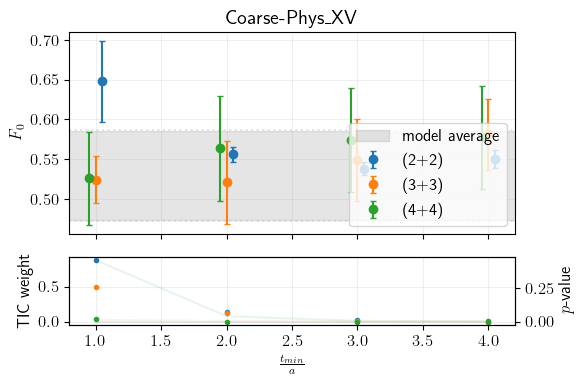

In [155]:
f, ax = plt.subplots(2,1,figsize=(6,4),gridspec_kw={'height_ratios': [3, 1]},sharex=True)

ts      = np.array([1,2,3,4])
tranges = [((t,robj.Ta-t)) for t in ts]

ax2 = ax[1].twinx()

for i,n in enumerate([1,2,3]):
    f0 = [robj.fits[n,tr].p['ratio'][0] for tr in tranges]
    off = -0.05*i + 0.05
    ax[0].errorbar(ts+off,gv.mean(f0),gv.sdev(f0),fmt='o', color=f'C{i}', capsize=2.5, label=f'({n+1}+{n+1})')

    tic = [np.exp(-TIC[n,tr]/2)/norm for tr in tranges]
    ax[1].plot(ts,tic,alpha=0.1,color=f'C{i}')
    # ax[1].scatter(ts,tic,marker='o',color=f'C{i}')

    pv = [pval[n,tr] for tr in tranges]
    ax2.scatter(ts,pv,color=f'C{i}',marker='.')


ax[0].axhspan(ymin=stat.mean-stat.sdev,ymax=stat.mean+stat.sdev,color='gray',alpha=0.2,label='model average')
err = np.sqrt(stat.sdev**2+syst**2)
ax[0].axhline(stat.mean-err,color='gray',alpha=0.2,linestyle=':')
ax[0].axhline(stat.mean+err,color='gray',alpha=0.2,linestyle=':')

ax[0].grid(alpha=0.2)
ax[0].legend(loc='lower right')
ax[0].set_ylabel(r'$F_0$')

ax[1].grid(alpha=0.2)
# ax[1].set_ylim(-0.1,1.1)
ax[1].set_ylabel(r'TIC weight')
ax[1].set_xlabel(r'$\frac{t_{min}}{a}$')

ax2.set_ylabel(r'$p$-value')

ax[0].set_title(f'{ENSEMBLE}_{RATIO}')

plt.tight_layout()
# plt.savefig(f'/Users/pietro/Desktop/model_average_{ENSEMBLE}_{RATIO}_{MOMENTUM}.pdf')